In [1]:
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import copy

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import moexalgo
from moexalgo import Ticker

import datetime

In [2]:
class Preprocessing:
    """Класс для загрузки и предобработки данных об акциях.

    Attributes:
        stock: Объект для получения данных об акциях
        stock_name: Биржевой тикер
        df: DataFrame с историческими данными
        scaler: Нормализатор данных
    """
    def __init__(self, stock_name: str, window_size: int = 60, horizon: int = 2):
        """Инициализирует объект для работы с данными акций.

        Args:
            stock_name: Биржевой тикер
        """
        self.stock = Ticker(stock_name)
        self.stock_name = stock_name
        self.df = None
        self.scaler = None
        self.train_size = None
        self.window_size = window_size
        self.horizon = horizon

    def create_data(self, start: str, end: str, period: str) -> pd.DataFrame:
        """Загружает исторические данные об акциях за указанный период.

        Args:
            start: Дата начала в формате 'YYYY-MM-DD'
            end: Дата окончания в формате 'YYYY-MM-DD'
            period: Гранулярность данных ('1min', '1h', '1d' и т.д.)

        Returns:
            pd.DataFrame: DataFrame с колонками:
                - begin: Временная метка
                - open: Цена открытия
                - close: Цена закрытия
                - high: Максимальная цена
                - low: Минимальная цена
        """
        data = self.stock.candles(start=start, end=end, period=period)
        self.df = pd.DataFrame(data)
        self.df['begin'] = pd.to_datetime(self.df['begin'])
        return self.df

    def create_plot(self, color: str = '#3498db', linewidth: int = 2, figsize: tuple = (12,6), grid: bool = True) -> None:
        """Визуализирует динамику цен закрытия акций.

        Args:
            color: Цвет линии графика (HEX-формат)
            linewidth: Толщина линии
            figsize: Размер графика (ширина, высота)
            grid: Отображать сетку (True/False)
        """
        plt.figure(figsize=figsize)
        plt.plot(self.df['begin'], self.df['close'], label=self.stock_name, color=color, linewidth=linewidth)

        plt.title(f"Цена акций {self.stock_name}", fontsize=14, pad=20)
        plt.xlabel("Дата", fontsize=12)
        plt.ylabel("Цена закрытия, руб.", fontsize=12)
        plt.legend()

        plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d'))
        plt.xticks(rotation=45)
        plt.grid(grid)
        plt.tight_layout()

        plt.show()

    def data_preparation(self):
        """Подготавливает данные для обучения модели.

        Выполняет:
        1. Нормализацию данных
        2. Разделение на train/test
        3. Создание временных окон
        4. Преобразование в формат DataLoader

        Args:
            window_size: Размер временного окна для создания последовательностей

        Returns:
            tuple: (train_loader, test_loader) - загрузчики данных
        """
        
        close = self.df['close']
        close = close.values.astype('float32')

        self.scaler = MinMaxScaler()
        scaled_data = self.scaler.fit_transform(close.reshape(-1,1))

        self.train_size = int(len(close) * 0.8)
        train = scaled_data[:self.train_size]
        test = scaled_data[self.train_size - self.window_size:]

        def create_data_for_prep(data):
            X, y = [], []
            last_start = len(data) - self.horizon + 1
            for i in range(self.window_size, last_start):
                X.append(data[i-self.window_size:i, 0])
                y.append(data[i:i+self.horizon, 0])
            return torch.Tensor(X), torch.Tensor(y) # X=[N, window_size, 1]; Y = [N, horizon, 1]

        X_train, y_train = create_data_for_prep(train)
        X_test, y_test = create_data_for_prep(test)

        X_train = X_train.unsqueeze(-1)
        X_test = X_test.unsqueeze(-1)

        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=96, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=96, shuffle=False)

        return train_loader, test_loader

    def inverse_transform(self, data):
        """Выполняет обратное преобразование нормализованных данных.

        Args:
            data: Нормализованные данные (0-1)

        Returns:
            np.ndarray: Данные в исходном масштабе
        """
        return self.scaler.inverse_transform(data)

In [3]:
class Trainer:
    """Класс для обучения и оценки моделей временных рядов.

    Attributes:
        model: Модель для обучения
        optimizer: Оптимизатор
        loss_fn: Функция потерь
        train_loader: Загрузчик обучающих данных
        test_loader: Загрузчик тестовых данных
        device: Устройство для вычислений (CPU/GPU)
    """
    def __init__(self, model: torch.nn.Module, optimizer: torch.optim.Optimizer, loss_fn, train_loader: DataLoader, test_loader: DataLoader, device: torch.device):

        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.best_model_test_loss = float('inf')
        self.best_model_weights = None

    def train(self):
        """Одна эпоха обучения модели.

        Returns:
            float: Среднее значение потерь на эпохе
        """
        self.model.train()
        train_loss = 0

        for x,y in self.train_loader:
            x, y = x.to(self.device), y.to(self.device)
            # previous = x[:, -1, 0].unsqueeze(-1)
            self.optimizer.zero_grad()
            output = self.model(x)
            loss = self.loss_fn(output, y.unsqueeze(-1))
            train_loss += loss.item()
            loss.backward()
            self.optimizer.step()

        train_loss /= len(self.train_loader)

        return train_loss

    @torch.inference_mode()
    def evaluate(self):
        """Оценка модели на тестовых данных.

        Returns:
            float: Среднее значение потерь на тестовой выборке
        """
        self.model.eval()
        test_loss = 0

        for x,y in self.test_loader:
            x,y = x.to(self.device), y.to(self.device)
            # previous = x[:, -1, 0].unsqueeze(-1)
            output = self.model(x)
            loss = self.loss_fn(output, y.unsqueeze(-1))
            test_loss += loss.item()

        test_loss /= len(self.test_loader)

        return test_loss

    def whole_cycle(self, num_epochs: int = 50) -> None:
        """Полный цикл обучения модели.

        Args:
            num_epochs: Количество эпох для обучения
        """
        train_loss_hist, test_loss_hist = [], []

        for epoch in range(num_epochs):
            train_loss = self.train()
            test_loss = self.evaluate()

            if test_loss < self.best_model_test_loss:
                self.best_model_test_loss = test_loss
                self.best_model_weights = copy.deepcopy(self.model.state_dict())

            train_loss_hist.append(train_loss)
            test_loss_hist.append(test_loss)
            print(f'Epoch {epoch + 1}/{num_epochs}: Loss: {train_loss}, Test loss: {test_loss}')

        if self.best_model_weights:
            self.model.load_state_dict(self.best_model_weights)

    @torch.inference_mode()
    def get_predictions(self, preprocessing: Preprocessing):
        test_preds = []
        original_val = []
        self.model.eval()
        for x,y in self.test_loader:
            x = x.to(self.device)
            preds = self.model(x).cpu().squeeze(-1).numpy()
            true = y.cpu().squeeze(-1).numpy()
            test_preds.append(preds)
            original_val.append(true)

        test_preds = np.vstack(test_preds)
        original_val = np.vstack(original_val)

        y_preds = preprocessing.inverse_transform(test_preds.reshape(-1, 1)).reshape(-1, preprocessing.horizon)
        y_true = preprocessing.inverse_transform(original_val.reshape(-1, 1)).reshape(-1, preprocessing.horizon)

        return y_preds, y_true

    def plot_predictions(self, preprocessing: Preprocessing, horizon_plot: int = 2):
        y_preds, y_true = self.get_predictions(preprocessing)
        
        dates = preprocessing.df['begin'].values
        start_index = preprocessing.train_size
        end_index = start_index + len(y_preds)
        dates_test = dates[start_index:end_index]
        
        plt.figure(figsize=(12,6))
        plt.plot(dates_test, y_true[:, horizon_plot], label=f'Реальные t+{horizon_plot+1}')
        plt.plot(dates_test, y_preds[:, horizon_plot], '--', label=f'Предсказания t+{horizon_plot+1}')
        plt.title(f"Предсказания для {preprocessing.stock_name}", fontsize=14, pad=20)
        plt.xlabel("День", fontsize=12)
        plt.ylabel("Цена закрытия, руб.", fontsize=12)
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def metrics(self, preprocessing: Preprocessing):
        y_preds, y_true = self.get_predictions(preprocessing)
        res_df = []
        for h in range(preprocessing.horizon):
            rmse = np.sqrt(np.mean((y_preds[:, h] - y_true[:, h])**2))
            mae = np.mean(np.abs(y_preds[:, h] - y_true[:, h]))
    
            pred_direct = np.sign(np.diff(y_preds[:, h]))
            true_direct = np.sign(np.diff(y_true[:, h]))
            dir_acc = 100 * np.mean(pred_direct == true_direct) 

            res_df.append({
                'horizon': h+1,
                'RMSE': round(rmse, 3),
                'MAE': round(mae, 3),
                'Direction (%)': round(dir_acc, 1)
            })

        return pd.DataFrame(res_df)

    def save_best_model(self, path: str = "best_model.pt"):
        """Сохранение лучшей модели"""
        if self.best_model_weights:
            torch.save({
                'state_dict': self.best_model_weights,
                'model_config': {
                    'input_size': self.model.input_size,
                    'hidden_size': self.model.hidden_size,
                    'output_size': self.model.output_size,
                    'num_layers': self.model.num_layers,
                    'dropout': self.model.dropout,
                }
            }, path)
        
        

In [7]:
class LossFunc(nn.Module):
    def __init__(self, alpha: float = 0.5):
        super().__init__()
        self.mse = nn.MSELoss()
        self.alpha = alpha

    def forward(self, predict, target, previous):
        loss_mse = self.mse(predict, target)

        delta_pred = predict - previous
        delta_true = target - previous
        label = (delta_true>0).float()

        loss_dir = binary_cross_entropy_with_logits(delta_pred, label)

        return loss_mse + self.alpha * loss_dir

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, output_size=1, 
                 enc_layers=1, dec_layers=1, dropout=0.2,
                 teacher_forcing_ratio=0.5, horizon=2):
        super().__init__()
        
        self.lstm_encoder = nn.LSTM(input_size, hidden_size, 
                                    num_layers=enc_layers, batch_first=True, dropout=dropout)
        self.enc_ln = nn.LayerNorm(hidden_size)
        self.lstm_decoder = nn.LSTM(output_size, hidden_size, 
                                    num_layers=dec_layers, batch_first=True, dropout=dropout)
        self.dec_ln = nn.LayerNorm(hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.dec_drop = nn.Dropout(dropout)
        
        self.tfr = teacher_forcing_ratio
        self.horizon = horizon

    def forward(self, src, trg=None): # src: [B, T, 1], trg: [B, H, 1], t-длина окна, h-длина горизонта
        _, (h, c) = self.lstm_encoder(src) # h, c: [L_enc, B, Hs], h-скрытое состояние, c-финальная ячейка, L_enc = enc_layers, Hs = hidden_size
        h = self.enc_ln(h)
        dec_input = src[:, -1:, :] # dec_input: [B, 1, 1]
        outputs = []
        H = self.horizon if trg is None else trg.size(1)
        for step in range(H):
            out, (h, c) = self.lstm_decoder(dec_input, (h, c)) # out: [B, 1, Hs]
            out = self.dec_ln(out)
            out = self.dec_drop(out)
            pred = self.linear(out) # pred: [B, 1, 1]
            outputs.append(pred)

            if trg is not None and torch.rand(1).item() < self.tfr:
                dec_input = trg[:, step:step+1, :]
            else: 
                dec_input = pred
            
        return torch.cat(outputs, dim=1)

In [39]:
class DirectLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, horizon=2, 
                 enc_layers=1, dropout=0.2):
        super().__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=enc_layers, batch_first=True, dropout=dropout)
        self.head = nn.Linear(hidden_size, horizon)

    def forward(self, src: torch.Tensor):
        enc_out, _ = self.lstm(src)
        out = self.head(enc_out[:, -1, :])
        return out.unsqueeze(-1)

In [9]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.att = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        energy = torch.tanh(self.att(x))
        scores = self.v(energy)
        attn_weights = torch.softmax(scores, dim=1)
        return torch.sum(x * attn_weights, dim=1)

class EnhancedStockModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, horizon=2, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
        )
        self.ln = nn.LayerNorm(hidden_size)
        self.attention = Attention(hidden_size)
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size//2, horizon)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.ln(out)
        context = self.attention(out)
        return self.head(context).unsqueeze(-1)

In [11]:
SBER_ticker = 'SBER'
T_bank_ticker = 'T'
GAZP_ticker = 'GAZP'
VTB_ticker = 'VTBR'
Lukoil_ticker = 'LKOH'
# Yandex_ticker = 'YDEX'
SFI_ticker = 'SFIN'
Sov_com_bank_ticker = 'SVCB'

In [13]:
Horizon = 15

In [50]:
ticker = Preprocessing(SBER_ticker, horizon=Horizon)
ticker.create_data(start='2010-01-01', end='2025-07-27', period='1d');

In [52]:
df = ticker.df
df

,open,close,high,low,value,volume,begin,end
0,86.56,86.69,88.17,85.51,1.302497e+10,149200144.0,2010-01-11,2010-01-11 23:59:59
1,86.55,85.00,86.77,84.90,1.118797e+10,130321911.0,2010-01-12,2010-01-12 23:59:59
2,84.30,86.61,87.23,84.10,1.106950e+10,128818253.0,2010-01-13,2010-01-13 23:59:59
3,87.50,87.55,87.87,86.75,9.745828e+09,111469807.0,2010-01-14,2010-01-14 23:59:59
4,87.50,88.15,88.67,87.16,1.252105e+10,142265882.0,2010-01-15,2010-01-15 23:59:59
...,...,...,...,...,...,...,...,...
3931,311.00,313.08,314.49,310.78,1.171845e+10,37399400.0,2025-07-23,2025-07-23 23:59:59
3932,313.09,310.83,313.99,309.75,8.668963e+09,27841890.0,2025-07-24,2025-07-24 23:59:55
3933,310.86,308.93,311.76,306.00,1.573107e+10,50866870.0,2025-07-25,2025-07-25 23:59:57
3934,309.35,308.91,309.95,308.86,4.142025e+08,1339260.0,2025-07-26,2025-07-26 23:59:57


In [74]:
df['day_of_week'] = df['begin'].dt.dayofweek
df['day_of_month'] = df['begin'].dt.day
df['month'] = df['begin'].dt.month
df['year'] = df['begin'].dt.year
df.drop(['begin', 'end'], axis=1, inplace=True)
df

,open,close,high,low,value,volume,day_of_week,day_of_month,month,year
0,86.56,86.69,88.17,85.51,1.302497e+10,149200144.0,0,11,1,2010
1,86.55,85.00,86.77,84.90,1.118797e+10,130321911.0,1,12,1,2010
2,84.30,86.61,87.23,84.10,1.106950e+10,128818253.0,2,13,1,2010
3,87.50,87.55,87.87,86.75,9.745828e+09,111469807.0,3,14,1,2010
4,87.50,88.15,88.67,87.16,1.252105e+10,142265882.0,4,15,1,2010
...,...,...,...,...,...,...,...,...,...,...
3931,311.00,313.08,314.49,310.78,1.171845e+10,37399400.0,2,23,7,2025
3932,313.09,310.83,313.99,309.75,8.668963e+09,27841890.0,3,24,7,2025
3933,310.86,308.93,311.76,306.00,1.573107e+10,50866870.0,4,25,7,2025
3934,309.35,308.91,309.95,308.86,4.142025e+08,1339260.0,5,26,7,2025


In [54]:

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['open', 'high', 'low', 'value', 'volume']])

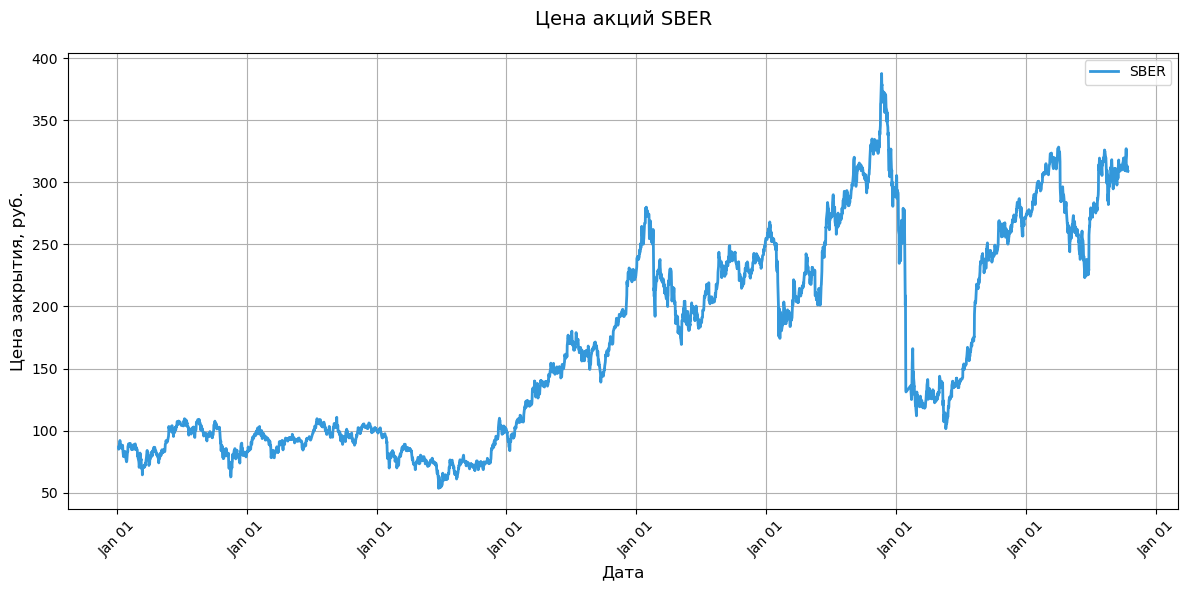

In [16]:
ticker.create_plot()

In [19]:
ticker_preproc = ticker.data_preparation()

C:\Users\Артем\AppData\Local\Temp\ipykernel_10956\3975539697.py:101: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.Tensor(X), torch.Tensor(y) # X=[N, window_size, 1]; Y = [N, horizon, 1]


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {torch.cuda.get_device_name()}")

Используемое устройство: NVIDIA GeForce GTX 1660 Ti


In [23]:
model = EnhancedStockModel(horizon=Horizon)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.HuberLoss()

In [24]:
trainer = Trainer(model, optimizer, loss_fn, ticker_preproc[0], ticker_preproc[1], device)


In [26]:
trainer.whole_cycle(num_epochs=150)

Epoch 1/150: Loss: 0.04048146739263426, Test loss: 0.10484864392007391
Epoch 2/150: Loss: 0.014328888215293939, Test loss: 0.017536626068047352
Epoch 3/150: Loss: 0.007684325827567866, Test loss: 0.005166103558925291
Epoch 4/150: Loss: 0.007252831668169661, Test loss: 0.0065902011443136465
Epoch 5/150: Loss: 0.007933571977032856, Test loss: 0.005198912921413366
Epoch 6/150: Loss: 0.009821006675448381, Test loss: 0.003256823508612191
Epoch 7/150: Loss: 0.00790538571274021, Test loss: 0.00823223429162883
Epoch 8/150: Loss: 0.0071421130222998645, Test loss: 0.006711012735548947
Epoch 9/150: Loss: 0.006993126900245746, Test loss: 0.0033595806291689062
Epoch 10/150: Loss: 0.0070401926059275866, Test loss: 0.011192622012458742
Epoch 11/150: Loss: 0.006932792095044119, Test loss: 0.010327854607668187
Epoch 12/150: Loss: 0.006716211273504252, Test loss: 0.01183286463169174
Epoch 13/150: Loss: 0.006809658392298981, Test loss: 0.009083100012503564
Epoch 14/150: Loss: 0.0066150568467988205, Test 

In [28]:
trainer.metrics(ticker)

,horizon,RMSE,MAE,Direction (%)
0,1,25.763000,20.513000,50.5
1,2,25.379000,20.233999,50.1
2,3,25.601999,20.427000,50.1
3,4,26.233999,20.900999,51.4
4,5,26.688999,21.219999,54.6
5,6,26.445000,21.024000,46.7
6,7,27.910999,22.191999,50.7
7,8,27.289000,21.561001,50.2
8,9,27.073999,21.252001,49.0
9,10,27.285999,21.360001,50.7


In [ ]:
preds, trues = trainer.get_predictions(ticker)

In [ ]:
preds

In [ ]:
trues

In [ ]:
test_model = LSTMModel(horizon=Horizon)
test_optimizer = optim.Adam(test_model.parameters(), lr=1e-2)
test_loss_fn = nn.HuberLoss()

In [ ]:
test_trainer = Trainer(test_model, test_optimizer, test_loss_fn, ticker_preproc[0], ticker_preproc[1], device)


In [ ]:
test_trainer.whole_cycle(num_epochs=150)

In [ ]:
test_trainer.metrics(ticker)

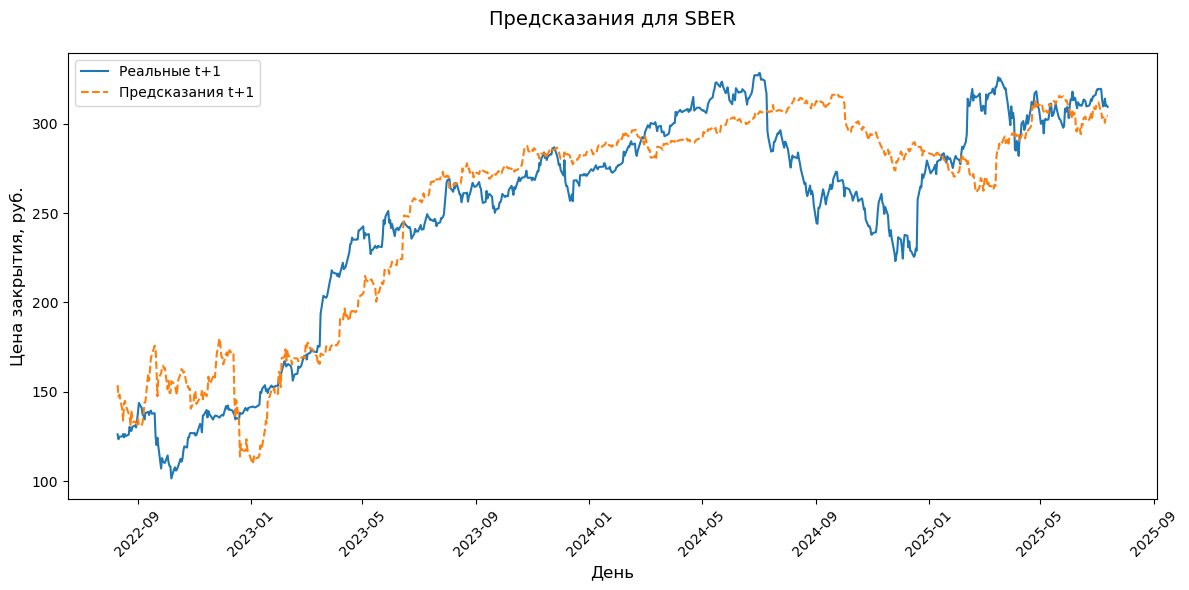

In [35]:
trainer.plot_predictions(ticker, 0)

In [ ]:
# trainer.save_best_model(path = f'model_{SBER_ticker}.pt')

In [ ]:
SBER_scaler = ticker.scaler

In [ ]:
from datetime import timedelta, datetime


def load_model(model_name: str):
    model_path = f'app/model_{model_name}.pt'
    checkpoint = torch.load(model_path, map_location='cpu')

    config = checkpoint['model_config']

    model = TestModel1(
        input_size=config['input_size'],
        hidden_size=config['hidden_size'],
        output_size=config['output_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout']
    )

    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    return model


In [ ]:
model = load_model(SBER_ticker)

In [ ]:
for lr in tqdm(lr_list, desc='LR'):
    for hidden_size in tqdm(hidden_size_list, desc='hidden_size'):
        model_t = LSTMModel(hidden_size=hidden_size)
        optimizer_t = optim.Adam(model_t.parameters(), lr=lr)
        trainer = Trainer(model_t, optimizer_t, loss_fn, dataloaders[0], dataloaders[1], device)
        trainer.whole_cycle(num_epochs=100)
        rmse, mae = trainer.metrics(stock)
        testing.append({
            'lr': lr,
            'hidden_size': hidden_size,
            'rmse': rmse,
            'mae': mae
        })
res_df = pd.DataFrame(testing)
res_sorted = res_df.sort_values('rmse')
print(res_df)
print('Лучшие комбинации')
print(res_sorted.head(7))

     lr  hidden_size    rmse     mae
2  0.01          256   5.815   4.020

     lr  hidden_size   rmse    mae
2  0.01          128  5.467  3.848